In [1]:
import os
os.chdir('../../modules/')


In [75]:
from util.util import *
from util.pred_blocks import ConvEncoder, GRUDecoder
from likelihood_predictor import PlastPredictor
from vae_generator import PlastVAEGen
import torch
from torchsummary import summary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

In [4]:
pl_ll = pd.read_pickle('../database/pl_likelihoods_v1.pkl')
org_ll = pd.read_pickle('../database/org_likelihoods_v1.pkl')

Test VAE with subset of data

In [97]:
test_data = pd.concat([pl_ll, org_ll]).sample(n=1000).to_numpy()
params = {'MAX_LENGTH': 120,
          'N_EPOCHS': 2}

In [98]:
pvg = PlastVAEGen(params=params)
pvg.initiate(test_data)

In [99]:
pvg.train()

Epoch - 0  Train Loss - 6.48  Val Loss - 4.96
Epoch - 1  Train Loss - 4.63  Val Loss - 4.59


Testing pre- and post-load to see if decode makes the same prediction

In [100]:
test_input = pvg.encoded[0,:,:].unsqueeze(0).cpu().numpy()

In [109]:
test_decode = pvg.predict(test_input)

In [102]:
smile = decode_smiles(test_input[0,:,:], pvg.ord_dict)
smile

'C1=CC2=C(C(=C1)O)N=CC=C2.C1=CC(=C(C=C1N)O)C(=O)O________________________________________________________________________'

In [113]:
smile = decode_smiles(test_decode[0,:,:], pvg.ord_dict)
smile

'5=CCCHNC(C][(]=COC4=__._C_(_CCO_Og=___(__]C____C_____C__CC_(___=__[[_____C___=_____C_O____(___7_____C___________3____OC_'

In [116]:
pvg2 = PlastVAEGen(params=params)
pvg2.load('checkpoints/latest.ckpt')
pvg2.best_loss

4.593737803007427

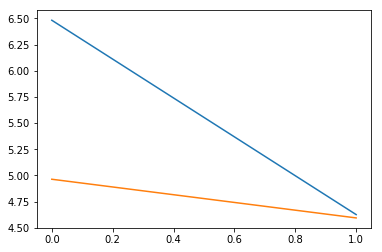

In [118]:
plt.plot(pvg.history['train_loss'])
plt.plot(pvg.history['val_loss'])
plt.show()

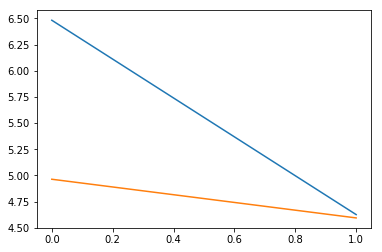

In [119]:
plt.plot(pvg2.history['train_loss'])
plt.plot(pvg2.history['val_loss'])
plt.show()

Encoder Testing

In [71]:
z, mu, logvar = pvg.encoder.forward(test_smi.float())
z.shape, mu.shape, logvar.shape

(torch.Size([292]), torch.Size([292]), torch.Size([292]))

In [72]:
z = pvg.encoder.reparameterize(mu, logvar)
z.shape

torch.Size([292])

In [73]:
summary(pvg.encoder, (pvg.input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 9, 112]           4,950
            Conv1d-2               [-1, 9, 104]             738
            Conv1d-3               [-1, 11, 95]           1,001
            Linear-4                       [-1]          57,524
            Linear-5                       [-1]          57,524
Total params: 121,737
Trainable params: 121,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.02
Params size (MB): 0.46
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


Decoder Testing

In [76]:
decoder = GRUDecoder(pvg.input_shape, pvg.latent_size)

In [79]:
x = decoder.forward(z, mu, logvar)

RuntimeError: input must have 3 dimensions, got 2

In [56]:
x.shape

torch.Size([120, 1, 61])

In [48]:
x.size()

torch.Size([120, 1, 488])